# Using Tensorflow DALI plugin with sparse tensors

### Overview

Using our DALI data loading and augmentation pipeline with Tensorflow is pretty simple.

However, sometimes a batch of data that uses wants to extract from the pipeline cannot be represented as a dense tensor. In such case, DALI op utilizes TensorFlow SparseTensor.
Please keep in mind that SparseTensors are supported only for the CPU based piepline.

### Defining the Data Loading Pipeline

First, we start by defining some simple pipeline that will return data as a sparse tensor. To ochieve this, we will use well known COCO data set. Each image may have 0 or more bounding boxes with labels describing objects present in it.Wa want to return images in a normalized way, while labels and bounding boxes will be represented as sparse tensors.
At the beginning let us define some global parameters

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali import pipeline_def, Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import os.path

test_data_root = os.environ["DALI_EXTRA_PATH"]

BATCH_SIZE = 32
test_data_root = os.environ["DALI_EXTRA_PATH"]
file_root = os.path.join(test_data_root, "db", "coco", "images")
annotations_file = os.path.join(test_data_root, "db", "coco", "instances.json")

Pipeline with the COCO reader is created. Please notice that while images are processed, other data from COCO ara passes through.

In [2]:
@pipeline_def
def coco_pipeline():
    jpegs, bboxes, labels, im_ids = fn.readers.coco(
        file_root=file_root,
        annotations_file=annotations_file,
        ratio=False,
        image_ids=True,
    )
    images = fn.decoders.image(jpegs, device="cpu")
    images = fn.resize(
        images,
        resize_shorter=fn.random.uniform(range=(256.0, 480.0)),
        interp_type=types.INTERP_LINEAR,
    )
    images = fn.crop_mirror_normalize(
        images,
        crop_pos_x=fn.random.uniform(range=(0.0, 1.0)),
        crop_pos_y=fn.random.uniform(range=(0.0, 1.0)),
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[128.0, 128.0, 128.0],
        std=[1.0, 1.0, 1.0],
    )
    images = fn.cast(images, dtype=types.INT32)

    return images, bboxes, labels, im_ids

Next, we instatiate the pipelines with the right parameters. We will create one pipeline per GPU, by specifying the right `device_id` for each pipeline.

The difference is that instead of calling `pipeline.build` and using it, we will pass the pipeline object to the TensorFlow operator.

In [3]:
pipe = coco_pipeline(batch_size=BATCH_SIZE, num_threads=2, device_id=0)

### Using DALI TensorFlow Plugin

Let's start by importing Tensorflow and the DALI Tensorflow plugin as `dali_tf`.

In [4]:
import tensorflow as tf
import nvidia.dali.plugin.tf as dali_tf
import time
from tensorflow.compat.v1 import GPUOptions
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import placeholder

tf.compat.v1.disable_eager_execution()

We can now use `nvidia.dali.plugin.tf.DALIIterator()` method to get the Tensorflow Op that will produce the tensors we will
use in the Tensorflow graph.

For each DALI pipeline, we use `daliop` that returns a Tensorflow tensor tuple that we will store in `image, bouding boxes, labels and image ids`.To enable sparse tensor generation `sparse` argument need to be filled with `True` values for the output elements that are going to be represented as a sparse tensors.

In [5]:
daliop = dali_tf.DALIIterator()

images = []
bboxes = []
labels = []
image_ids = []

with tf.device("/cpu"):
    image, bbox, label, id = daliop(
        pipeline=pipe,
        shapes=[(BATCH_SIZE, 3, 224, 224), (), (), ()],
        dtypes=[tf.int32, tf.float32, tf.int32, tf.int32],
        sparse=[False, True, True],
    )

    images.append(image)
    bboxes.append(bbox)
    labels.append(label)
    image_ids.append(id)

### Using the Tensors in a Simple Tensorflow Graph

We will use `images`, `bboxes`, `labels` and `image_ids` tensors list in our Tensorflow graph definition.
Then run a very simple _one op graph_ session that will output the batch of data. Then we will print bounding boxes, labels and image_ids.

In [6]:
with Session() as sess:
    all_img_per_sec = []
    total_batch_size = BATCH_SIZE

    start_time = time.time()

    # The actual run with our dali_tf tensors
    res_cpu = sess.run([images, bboxes, labels, image_ids])

print(res_cpu[1])
print(res_cpu[2])
print(res_cpu[3])

[SparseTensorValue(indices=array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       [ 0,  0,  3],
       [ 1,  0,  0],
       [ 1,  0,  1],
       [ 1,  0,  2],
       [ 1,  0,  3],
       [ 2,  0,  0],
       [ 2,  0,  1],
       [ 2,  0,  2],
       [ 2,  0,  3],
       [ 3,  0,  0],
       [ 3,  0,  1],
       [ 3,  0,  2],
       [ 3,  0,  3],
       [ 3,  1,  0],
       [ 3,  1,  1],
       [ 3,  1,  2],
       [ 3,  1,  3],
       [ 4,  0,  0],
       [ 4,  0,  1],
       [ 4,  0,  2],
       [ 4,  0,  3],
       [ 5,  0,  0],
       [ 5,  0,  1],
       [ 5,  0,  2],
       [ 5,  0,  3],
       [ 6,  0,  0],
       [ 6,  0,  1],
       [ 6,  0,  2],
       [ 6,  0,  3],
       [ 7,  0,  0],
       [ 7,  0,  1],
       [ 7,  0,  2],
       [ 7,  0,  3],
       [ 8,  0,  0],
       [ 8,  0,  1],
       [ 8,  0,  2],
       [ 8,  0,  3],
       [ 9,  0,  0],
       [ 9,  0,  1],
       [ 9,  0,  2],
       [ 9,  0,  3],
       [ 9,  1,  0],
       [ 9,  1,  1],
       

Let us check the output images with their augmentations! Tensorflow outputs numpy arrays, so we can visualize them easily with `matplotlib`.

We define a `show_images` helper function that will display a sample of our batch.

The batch layout is NCHW so we use transpose to get HWC images, that `matplotlib` can show.

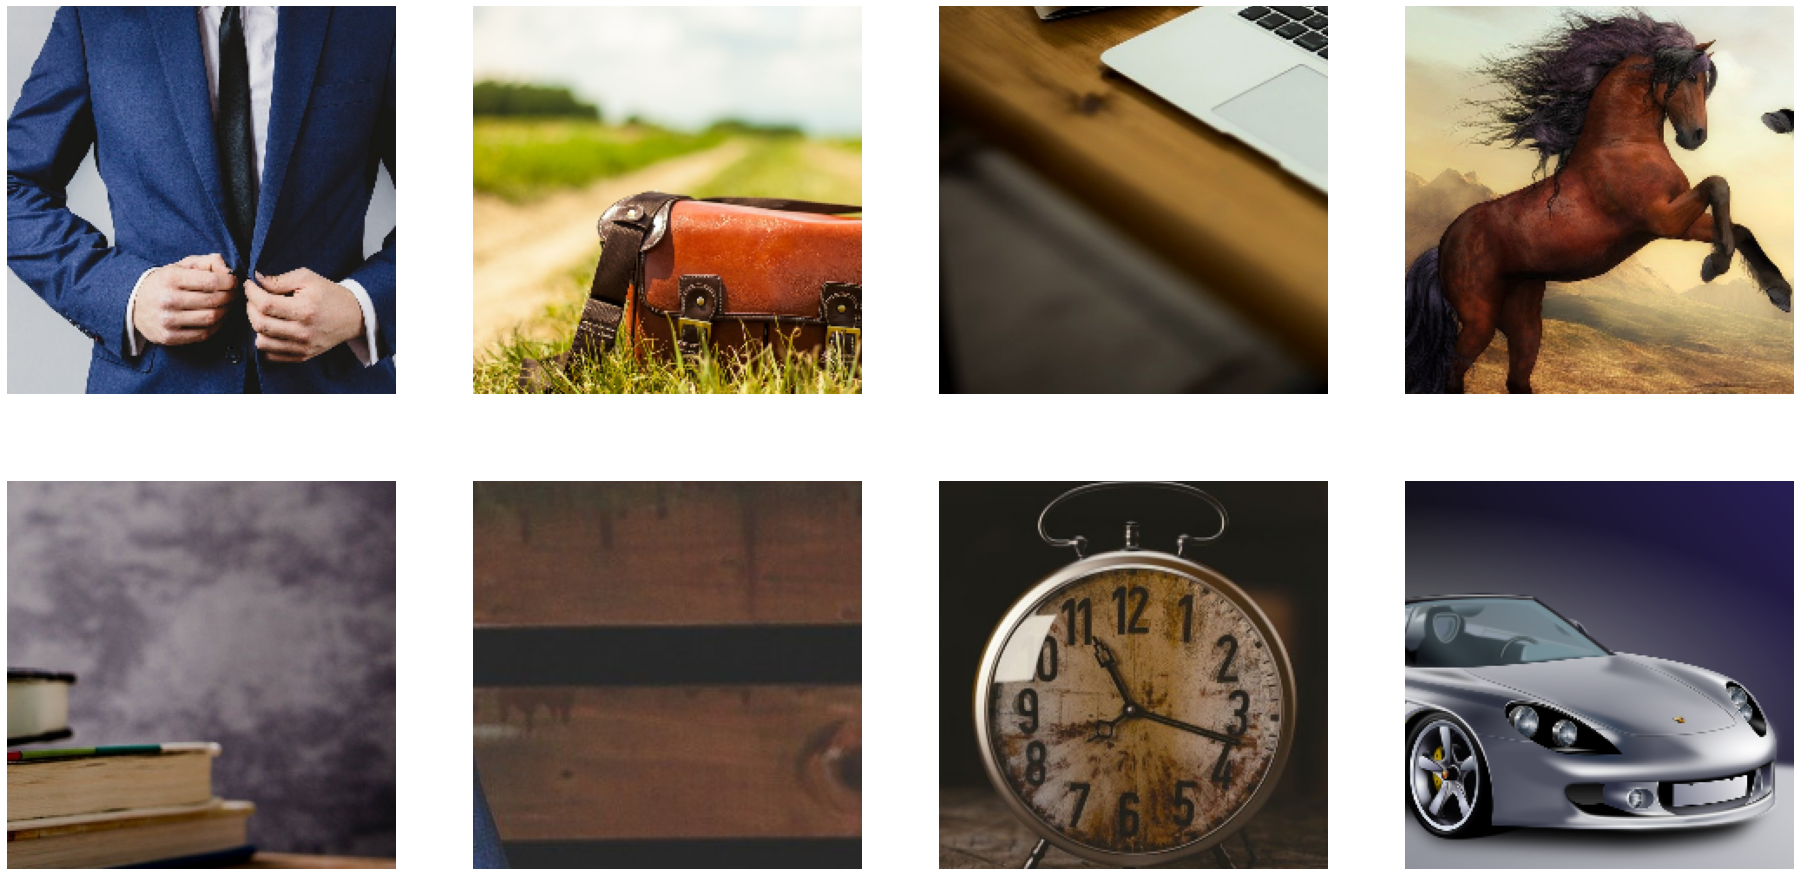

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(image_batch, nb_images):
    columns = 4
    rows = (nb_images + 1) // (columns)
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(nb_images):
        plt.subplot(gs[j])
        plt.axis("off")
        img = image_batch[0][j].transpose((1, 2, 0)) + 128
        plt.imshow(img.astype("uint8"))


show_images(res_cpu[0], 8)